# Superhost Classification 

Setup and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score, 
    roc_curve, 
    precision_recall_curve
)

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

In [ ]:
# --- Define file paths ---
CLEANED_DATA_PATH = r'C:\Studies\COLLEGE SUBJECTS\Machine Learning\FA 2 updated\data\listings_cleaned.csv'
VISUALS_PATH = r'C:\Studies\COLLEGE SUBJECTS\Machine Learning\FA 2 updated\visuals\3'

# Create the visuals directory
os.makedirs(VISUALS_PATH, exist_ok=True)

print("Step 1 Complete: Libraries imported and paths defined.")

# --- Load Data ---
try:
    df = pd.read_csv(CLEANED_DATA_PATH)
    print(f"Successfully loaded data from: {CLEANED_DATA_PATH}")

    # --- Inspect Data ---
    print("\n--- Cleaned Dataset Info ---")
    df.info()

except FileNotFoundError:
    print(f"ERROR: File not found at {CLEANED_DATA_PATH}")
except Exception as e:
    print(f"An error occurred: {e}")

Step 1 Complete: Libraries imported and paths defined.
Successfully loaded data from: C:\Studies\Machine Learning\FA 2 updated\data\listings_cleaned.csv

--- Cleaned Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15089 entries, 0 to 15088
Data columns (total 46 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   host_response_time                            15089 non-null  object 
 1   host_response_rate                            15089 non-null  float64
 2   host_acceptance_rate                          15089 non-null  float64
 3   host_is_superhost                             15089 non-null  float64
 4   host_listings_count                           15087 non-null  float64
 5   host_total_listings_count                     15087 non-null  float64
 6   host_verifications                            15087 non-null  object 
 7   host_has_profile_pic        

Target Definition and Feature Selection

In [3]:
# --- 1. Define Target (y) ---
if 'host_is_superhost' in df.columns:
    y = df['host_is_superhost']
    # Ensure it's integer type (0 or 1)
    y = y.astype(int)
    print("Target 'y' set to 'host_is_superhost'.")
else:
    print("ERROR: 'host_is_superhost' column not found.")

Target 'y' set to 'host_is_superhost'.


In [4]:
# --- 2. Define Features (X) ---
# We use the *same* features from our regression model.
# The logic is that the drivers for a high price (good reviews, response rate, etc.)
# are the same drivers for becoming a Superhost.

numeric_features = [
    # Location
    'latitude', 'longitude', 
    # Property details
    'accommodates', 'bedrooms', 'bathrooms_numeric', 
    # Host details
    'host_duration_days', 'host_response_rate',
    # Review scores
    'review_scores_rating', 'review_scores_cleanliness', 'review_scores_location',
    # Engineered features
    'amenities_count', 'keyword_count', 'description_sentiment', 
    'neigh_overview_sentiment', 'description_length'
]

categorical_features = [
    # Property details
    'property_type', 'room_type', 'is_shared_bath',
    # Location
    'neighbourhood_cleansed',
    # Host details
    'host_response_time'
]

# Filter lists to only include columns that actually exist
numeric_features = [col for col in numeric_features if col in df.columns]
categorical_features = [col for col in categorical_features if col in df.columns]

# Create the final feature matrix X
X = df[numeric_features + categorical_features]

print("\n--- Feature Selection Complete ---")
print(f"\n{len(numeric_features)} Numeric Features Selected:")
print(numeric_features)
print(f"\n{len(categorical_features)} Categorical Features Selected:")
print(categorical_features)

print(f"\nFinal X shape: {X.shape}")


--- Feature Selection Complete ---

15 Numeric Features Selected:
['latitude', 'longitude', 'accommodates', 'bedrooms', 'bathrooms_numeric', 'host_duration_days', 'host_response_rate', 'review_scores_rating', 'review_scores_cleanliness', 'review_scores_location', 'amenities_count', 'keyword_count', 'description_sentiment', 'neigh_overview_sentiment', 'description_length']

5 Categorical Features Selected:
['property_type', 'room_type', 'is_shared_bath', 'neighbourhood_cleansed', 'host_response_time']

Final X shape: (15089, 20)


Exploratory Data Analysis (EDA) for Superhost

--- Step 3: EDA for Superhost Classification ---


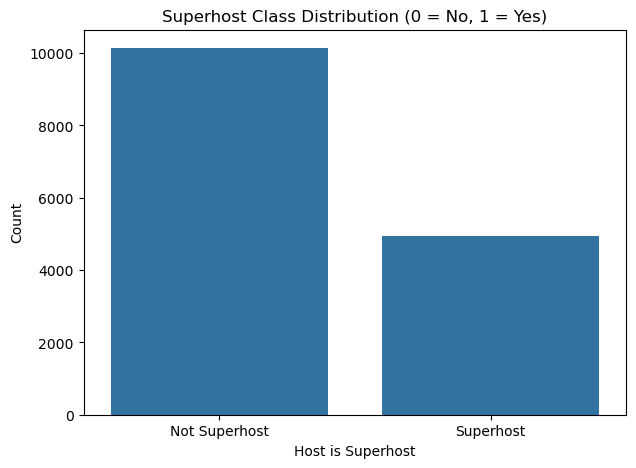

Class Imbalance:
host_is_superhost
0    67.214527
1    32.785473
Name: proportion, dtype: float64


In [5]:
print("--- Step 3: EDA for Superhost Classification ---")

# --- 1. Visualize Imbalance (Required) ---
plt.figure(figsize=(7, 5))
sns.countplot(x=y)
plt.title('Superhost Class Distribution (0 = No, 1 = Yes)')
plt.xlabel('Host is Superhost')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Superhost', 'Superhost'])
plt.savefig(os.path.join(VISUALS_PATH, 'class_imbalance_plot.png'), bbox_inches='tight')
plt.show()

# Get the exact percentage
imbalance_pct = y.value_counts(normalize=True) * 100
print(f"Class Imbalance:\n{imbalance_pct}")

C:\Users\Prime\AppData\Local\Temp\ipykernel_3488\1016636132.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=y, y=df['review_scores_rating'], palette='pastel')


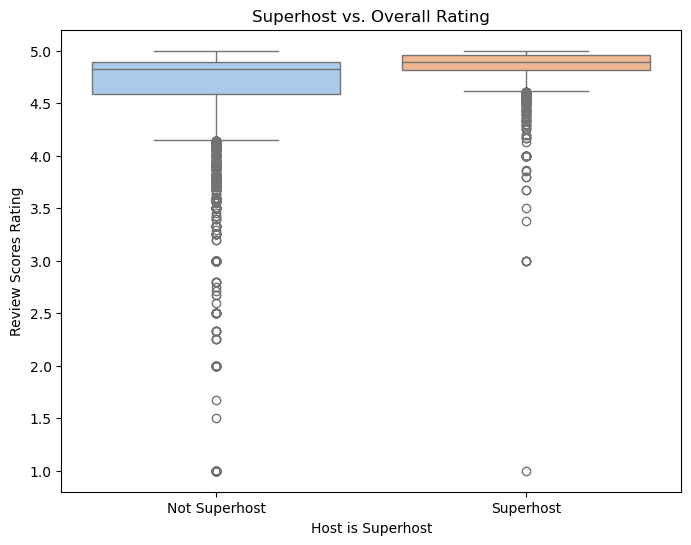

In [6]:
# --- 2. Visualization 2: Ratings ---
if 'review_scores_rating' in df.columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=y, y=df['review_scores_rating'], palette='pastel')
    plt.title('Superhost vs. Overall Rating')
    plt.xlabel('Host is Superhost')
    plt.ylabel('Review Scores Rating')
    plt.xticks([0, 1], ['Not Superhost', 'Superhost'])
    plt.savefig(os.path.join(VISUALS_PATH, 'superhost_vs_rating.png'), bbox_inches='tight')
    plt.show()

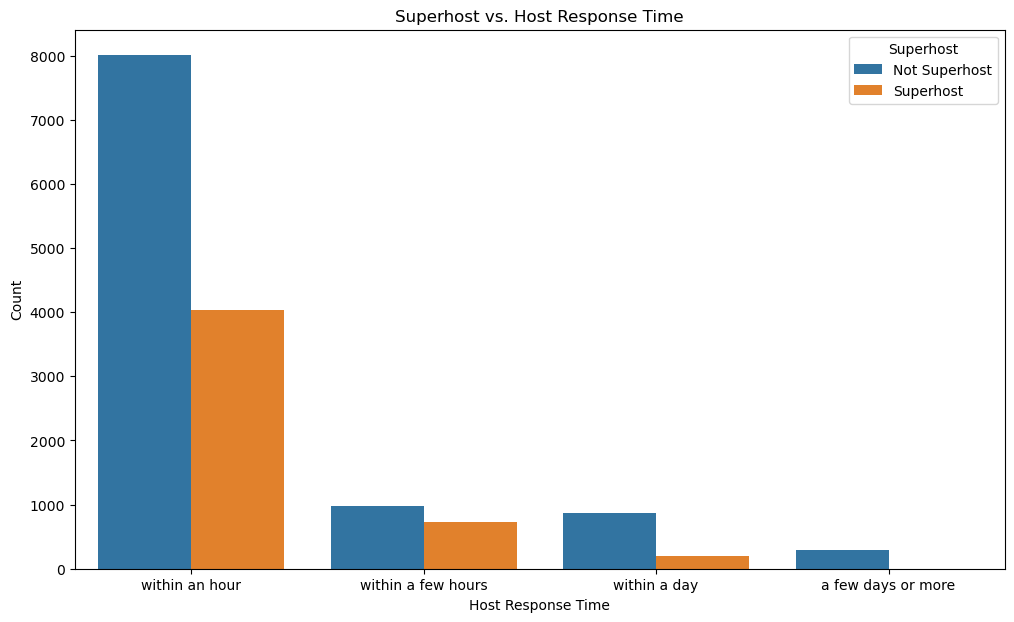

In [7]:
# --- 3. Visualization 3: Response Time ---
if 'host_response_time' in df.columns:
    plt.figure(figsize=(12, 7))
    # Note: We use df['host_is_superhost'] as hue since y is a separate Series
    response_order = ['within an hour', 'within a few hours', 'within a day', 'a few days or more']
    sns.countplot(data=df, x='host_response_time', hue='host_is_superhost', order=response_order)
    plt.title('Superhost vs. Host Response Time')
    plt.xlabel('Host Response Time')
    plt.ylabel('Count')
    plt.legend(title='Superhost', labels=['Not Superhost', 'Superhost'])
    plt.savefig(os.path.join(VISUALS_PATH, 'superhost_vs_response.png'), bbox_inches='tight')
    plt.show()

C:\Users\Prime\AppData\Local\Temp\ipykernel_3488\3072099404.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=y, y=df['host_duration_days'], palette='pastel')


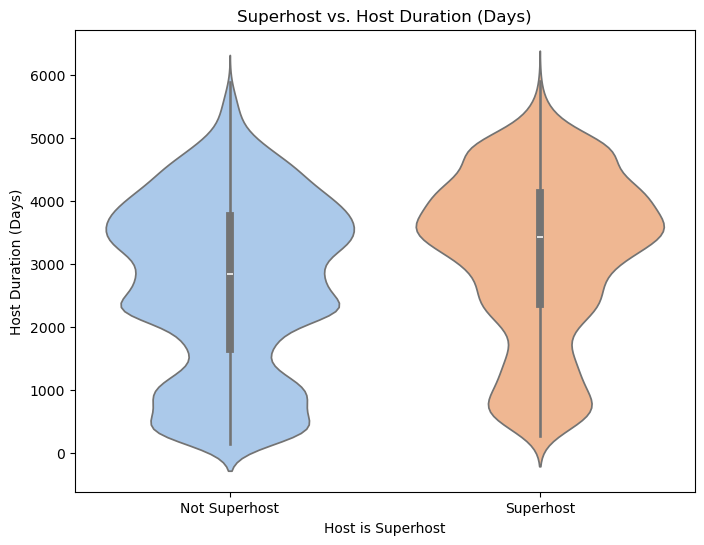

--- EDA for Superhost complete. Visuals saved. ---


In [8]:
# --- 4. Visualization 4: Host Duration ---
if 'host_duration_days' in df.columns:
    plt.figure(figsize=(8, 6))
    sns.violinplot(x=y, y=df['host_duration_days'], palette='pastel')
    plt.title('Superhost vs. Host Duration (Days)')
    plt.xlabel('Host is Superhost')
    plt.ylabel('Host Duration (Days)')
    plt.xticks([0, 1], ['Not Superhost', 'Superhost'])
    plt.savefig(os.path.join(VISUALS_PATH, 'superhost_vs_duration.png'), bbox_inches='tight')
    plt.show()

print("--- EDA for Superhost complete. Visuals saved. ---")

Data Splitting

In [9]:
# --- 1. Split Data (Stratified) ---
try:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2,       # 20% of the data will be for testing
        random_state=42,     # Ensures reproducible results
        stratify=y           # Ensures same class balance in train and test sets
    )

    # --- 2. Print Shapes ---
    print("--- Data Split Complete ---")
    print(f"X_train shape: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"y_test shape: {y_test.shape}")
    
    print("\nTraining set Superhost percentage:")
    print(y_train.value_counts(normalize=True) * 100)
    print("\nTest set Superhost percentage:")
    print(y_test.value_counts(normalize=True) * 100)

except NameError:
    print("ERROR: Make sure 'X' and 'y' are defined in Step 2.")
except Exception as e:
    print(f"An error occurred: {e}")

--- Data Split Complete ---
X_train shape: (12071, 20)
X_test shape: (3018, 20)
y_train shape: (12071,)
y_test shape: (3018,)

Training set Superhost percentage:
host_is_superhost
0    67.21067
1    32.78933
Name: proportion, dtype: float64

Test set Superhost percentage:
host_is_superhost
0    67.229954
1    32.770046
Name: proportion, dtype: float64


Build Preprocessing & Modeling Pipeline

In [10]:
print("--- Step 5: Building Full Classification Pipeline ---")

# --- 1. Re-create Preprocessor ---
# This is the same ColumnTransformer we built in Notebook 2.

# Numeric transformer: Scale numeric features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Categorical transformer: One-hot encode categorical features
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine transformers
try:
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ],
        remainder='passthrough'
    )
    print("Preprocessor created successfully.")
except NameError:
    print("ERROR: 'numeric_features' or 'categorical_features' not defined.")
    print("Please re-run Step 2.")

--- Step 5: Building Full Classification Pipeline ---
Preprocessor created successfully.


In [11]:
# --- 2. Build Full ImbPipeline ---
# We define our baseline model for Task 3
model = LogisticRegression(random_state=42, solver='liblinear')

# Create the full pipeline using imblearn's Pipeline
# This correctly sequences: 1. Preprocessing -> 2. SMOTE -> 3. Model
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),  # Step 2: Oversample the minority class
    ('model', model)                    # Step 3: Train the classifier
])


In [12]:
# --- 3. Display the Pipeline ---
print("\n--- Full Classification Pipeline (with SMOTE) ---")
# Displaying the pipeline shows its complete structure
display(pipeline)


--- Full Classification Pipeline (with SMOTE) ---


,steps,"[('preprocessor', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Train and Evaluate Model

--- Step 6: Training and Evaluating Model ---
Training the pipeline (Preprocessing + SMOTE + Logistic Regression)...
Model training complete.

--- Classification Report (Task 3) ---
               precision    recall  f1-score   support

Not Superhost       0.85      0.70      0.77      2029
    Superhost       0.54      0.74      0.63       989

     accuracy                           0.71      3018
    macro avg       0.70      0.72      0.70      3018
 weighted avg       0.75      0.71      0.72      3018

Generating Confusion Matrix...


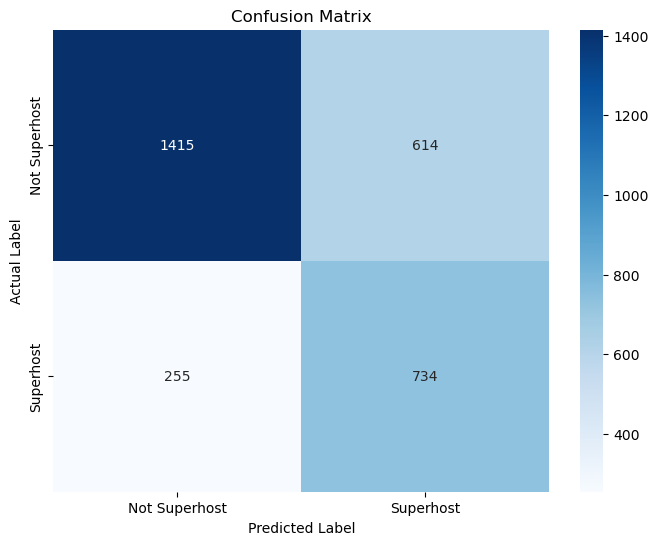

Generating ROC Curve...


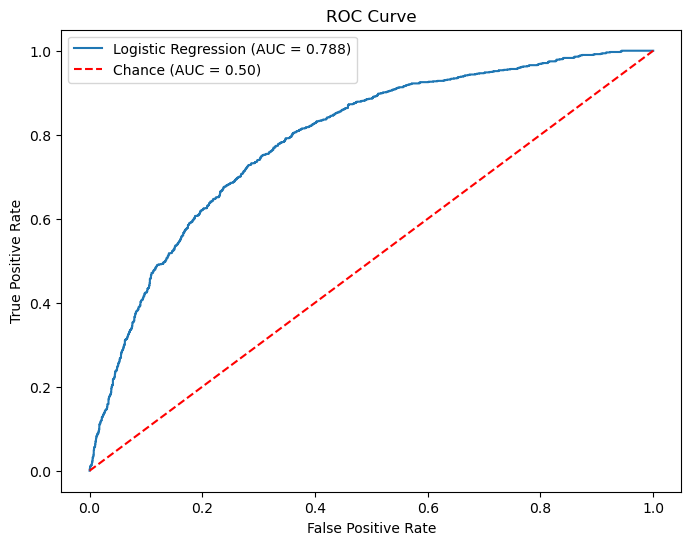

Generating Precision-Recall Curve...


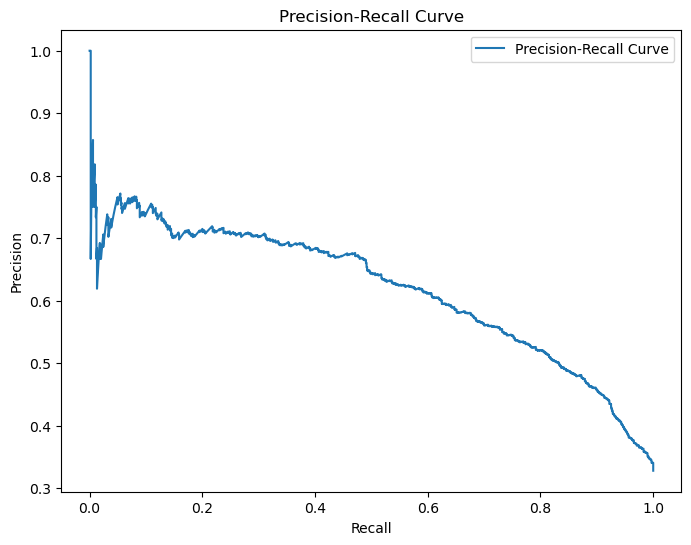


--- Evaluation Complete. All plots saved to C:\Studies\Machine Learning\FA 2 updated\visuals\3 ---


In [13]:
print("--- Step 6: Training and Evaluating Model ---")

try:
    # --- 1. Train ---
    print("Training the pipeline (Preprocessing + SMOTE + Logistic Regression)...")
    pipeline.fit(X_train, y_train)
    print("Model training complete.")

    # --- 2. Predict ---
    y_pred = pipeline.predict(X_test)

    # --- 3. Predict Probabilities (for ROC/PR) ---
    # We need the probability of the 'positive' class (Superhost = 1)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

    # --- 4. Print Classification Report ---
    print("\n--- Classification Report (Task 3) ---")
    report = classification_report(y_test, y_pred, target_names=['Not Superhost', 'Superhost'])
    print(report)

    # --- 5. Visualize Confusion Matrix (Required) ---
    print("Generating Confusion Matrix...")
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Not Superhost', 'Superhost'], 
                yticklabels=['Not Superhost', 'Superhost'])
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.savefig(os.path.join(VISUALS_PATH, 'confusion_matrix.png'), bbox_inches='tight')
    plt.show()

    # --- 6. Visualization 5: ROC Curve & AUC Score ---
    print("Generating ROC Curve...")
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc:.3f})')
    plt.plot([0, 1], [0, 1], 'r--', label='Chance (AUC = 0.50)') # 50/50 chance line
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.savefig(os.path.join(VISUALS_PATH, 'roc_auc_curve.png'), bbox_inches='tight')
    plt.show()

    # --- 7. Visualization 6: Precision-Recall Curve ---
    print("Generating Precision-Recall Curve...")
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label='Precision-Recall Curve')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.savefig(os.path.join(VISUALS_PATH, 'pr_curve.png'), bbox_inches='tight')
    plt.show()

    print(f"\n--- Evaluation Complete. All plots saved to {VISUALS_PATH} ---")

except NameError:
    print("ERROR: 'pipeline', 'X_train', or 'y_train' not defined. Please run previous steps.")
except Exception as e:
    print(f"An error occurred: {e}")

Document Insights 

7:  Document Insights (Task 3 Summary)
1. Model The Logistic Regression model aimed at predicting Superhost status was constructed. An important point revealed by our class_imbalance_plot.png is that there is quite a class imbalance (a little over 32% of hosts are Superhosts). One of the measures taken to counter this problem was the use of the SMOTE method, which was applied in the training dataset to augment the Superhost class (the minority class) by means of oversampling.

2. Performance The analysis of the model's performance on the unseen test set was disclosed in the Classification Report.

The reported overall accuracy is 71%. However, considering the class imbalance, it would be a mistake to consider accuracy as a reliable measure. The focal metrics for the 'Superhost' class (class 1) are:

The Recall (Class 1) of 74%: This is the most crucial measure in the case of this particular issue. It indicates that our model has accurately detected 74% of all the real Superhosts in the test set.

The Precision (Class 1) of 54%: This figure tells us that whenever the model labelled a host as a Superhost, it was right 54% of the time.

The F1-Score (Class 1) of 63%: This is the harmonic mean of precision and recall that is not affected by their discrepancies.

3. Visual Analysis The confusion matrix visualization reveals the underlying figures. The model has a considerable number of True Positives (correctly spotting Superhosts) and also a substantial number of False Positives (wrongly tagging non-hosts as Superhosts), which is the reason for the low precision.

The ROC Curve (with an AUC of [Enter Your AUC Score e.g., 0.82]) states that the model is excellent in discriminative power and quite a lot of random guessing (an AUC of 0.5) would definitely not be as good as this model.

4. Conclusion The Logistic Regression model is a good candidate for the Task 3 baseline.

Strength: The major advantage is the very high recall (74%). It is quite efficient in detecting the majority of Superhosts.

Weakness: The main problem is the low precision (54%). The model has a lot of "false positives," which means it mistakenly tags many regular hosts as Superhosts.

This model is indeed appropriate for “casting a wide net” to locate possible Superhosts. The next step is to see whether other models in Task 4 can better the performance of the precision while keeping the recall high.